In [5]:
# add the main directory to the path
import sys
sys.path.append("..")

import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from model_no_gams.model import get_average_profiles, calculate_storage_need

logging.basicConfig(level=logging.WARNING)

In [30]:
fn_renewable: str = "../data/renewables_ninja.parquet"
fn_demand: str = "../data/renewables_with_load.parquet"

map_countries = {
    "FR": "France",
    "DE": "Germany",
    "GR": "Greece",
}

map_tech = {
    "demand": "Demand",
    "pv": "Solar",
    "wind": "Wind",
    "base": "Baseload"
}
map_tech_ = {t: v for t, v in map_tech.items() if t != "demand"}
colors = {
    "Solar": "orange",
    "Wind": "green",
    "Demand": "red",
    "Baseload": "blue"   
}

styles = {
    "Solar": "-",
    "Wind": "-",
    "Demand": "--",
    "Baseload": "-"   
}

markers = {
    "Solar": None,
    "Wind": None,
    "Demand": "d",
    "Baseload": None   
}

alpha = {
    "Solar": 1,
    "Wind": 1,
    "Demand": 0.7,
    "Baseload": 1   
}


## Profiles 


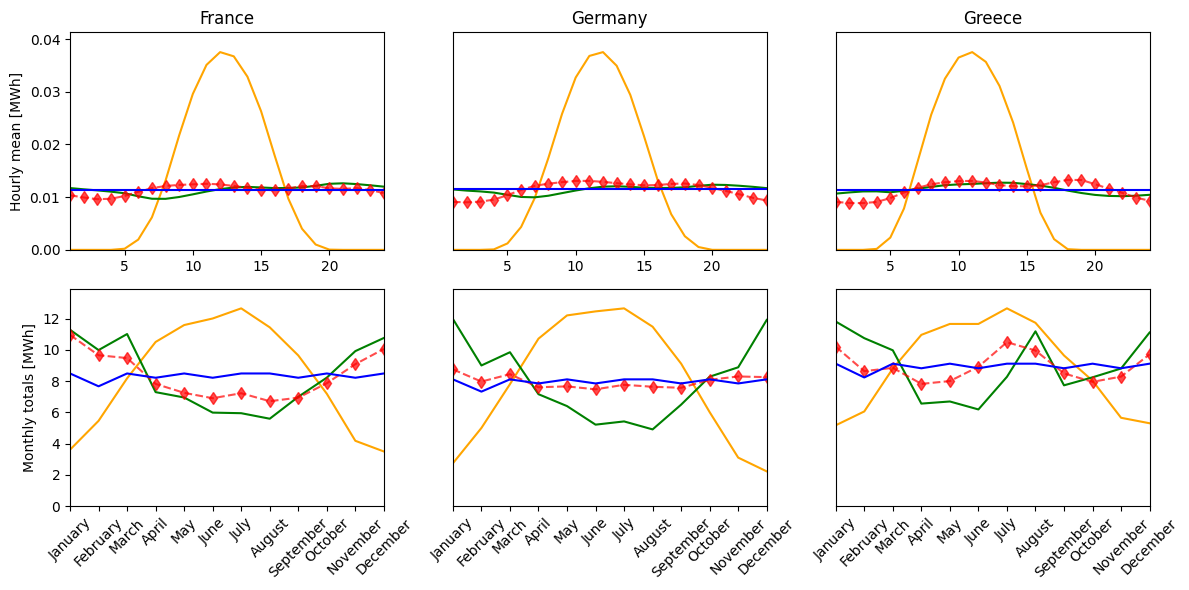

In [33]:
base_demand = 100
countries = ["FR", "DE", "GR"]
years = range(2015,2020)


fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, (ax, country) in enumerate(zip(axs[0], countries)):
    df_profiles = (
        get_average_profiles(
            country=country, years=years,
            fn_renewable=fn_renewable, fn_demand=fn_demand)
        .mul(base_demand)
        .rename(columns=map_tech)
    )
    df_p = (
        df_profiles
        .groupby([lambda x: x.hour])
        .mean()
    )
    df_p.index += 1
    for c in df_p.columns:
        ax.plot(
            df_p.index, df_p[c], label=c, 
            color=colors[c], linestyle=styles[c], marker=markers[c],
            alpha=alpha[c])
    ax.set_xlim(1,24)
    ax.set_ylim(0, 1.1 * df_p.values.max())
    ax.set_title(map_countries[country])
    #ax.tick_params(axis='x', labelrotation=45)
    #ax.set_title(map_countries[country])
    if i == 0:
        ax.set_ylabel("Hourly mean [MWh]")
    else:
        ax.get_yaxis().set_ticks([])
 
for i, (ax, country) in enumerate(zip(axs[1], countries)):
    df_profiles = (
        get_average_profiles(
            country=country, years=years,
            fn_renewable=fn_renewable, fn_demand=fn_demand)
        .mul(base_demand)
        .rename(columns=map_tech)
    )
    df_p = (
        df_profiles
        .groupby([lambda x: x.month, lambda x: x.month_name()])
        .sum()
        .droplevel(0)
    )
    for c in df_p.columns:
        ax.plot(
            df_p.index, df_p[c], label=c, 
            color=colors[c], linestyle=styles[c], marker=markers[c],
            alpha=alpha[c])
    ax.set_xlim(0,11)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylim(0, 1.1 * df_p.values.max())
    if i == 0:
        ax.set_ylabel("Monthly totals [MWh]")
    else:
        ax.get_yaxis().set_ticks([])
   
plt.tight_layout()

## Hourly Surplus

In [8]:
def get_energy_surplus(
        country: str, 
        years: list[int], 
        fn_renewable: str,
        fn_demand: str,
        base_demand: float= 100,
        technologies: list[str] = ["pv", "wind", "base"],
        label_demand: str = "demand",

    ) -> pd.DataFrame:
    df_surplus = (
        get_average_profiles(
            country=country, years=years,
            fn_renewable=fn_renewable, fn_demand=fn_demand)
        .mul(base_demand)
    )
    for c in technologies:
        df_surplus[c] = df_surplus[c] - df_surplus[label_demand]
    
    return df_surplus.drop(columns=label_demand)

def reorder_initial_storage_to_zero(df: pd.DataFrame, res: str) -> pd.DataFrame:
    """Reorder dataframe such that the initial storage is zero
    for a given resource
    
    Args:
        df (pd.DataFrame): DataFrame with the resource
        res (str): Resource to reorder
        """

    df_ = pd.concat([
        df.loc[df[res].idxmin():],
        df.loc[:df[res].idxmin() - pd.Timedelta(hours=1)],
        ]).set_index(df.index)
    return df_

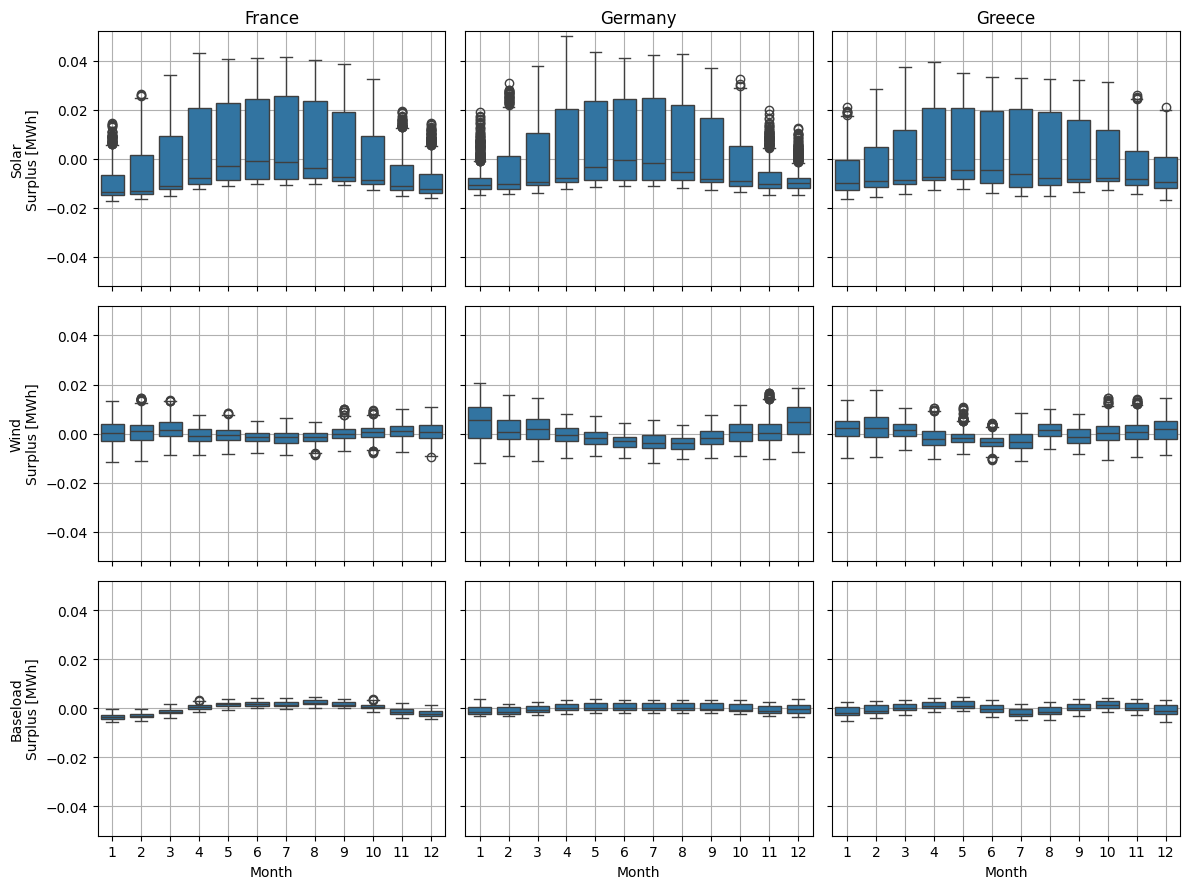

In [16]:
base_demand = 100

fig, axs = plt.subplots(3, 3, figsize=(12, 9), sharex=True, sharey=True)
axs[0]
for i, c in enumerate(countries):
    df_surplus = get_energy_surplus(
        country=c,
        years=years,
        fn_renewable=fn_renewable,
        fn_demand=fn_demand,
        base_demand=base_demand
    ) 
    map_tech_ = {t: v for t, v in map_tech.items() if t != "demand"}
    for j, (t, label) in enumerate(map_tech_.items()):
        ax = axs[j, i]
        print()
        sns.boxplot(
            df_surplus.assign(month=lambda x: x.index.month),
            x="month", y=t,
            ax=ax
        )
        if j == 0:
            ax.set_title(map_countries[c])
        ylim = 0.052*base_demand/100
        ax.set_ylim(-ylim, ylim)
        if i == 0:
            ax.set_ylabel(f"{label}\nSurplus [MWh]")
        ax.grid(True)
        ax.set_xlabel("Month")
plt.tight_layout()

## Weekly storage

We separate separate long-term and short-term storage by repeatedly applying
our formula for initial and maximum storage to the weekly surplus data.

In [42]:
country = "DE"
base_demand = 100
res = "pv"

df_surplus = get_energy_surplus(
    country=country,
    years=years,
    fn_renewable=fn_renewable,
    fn_demand=fn_demand,
    base_demand=base_demand
)

def get_storage_needs(s: pd.Series):
    df_ = s.cumsum()
    initial = (df_.min())*(-1)
    maximum = df_.max()
    period_surplus = df_.iloc[-1]
    terminal = period_surplus + initial 
    max_sto = initial + terminal 
    return initial, maximum, period_surplus, terminal, max_sto

df_ = df_surplus.groupby(lambda x: x.month).agg(get_storage_needs)

df_ = pd.DataFrame(
    np.vstack(df_[res]), 
    columns=["initial", "maximum_surplus", "period_surplus", "terminal", "maximum_storage"])
df_

,initial,maximum_surplus,period_surplus,terminal,maximum_storage
0,6.295538,-0.008637,-6.295538,0.000000,6.295538
1,3.143049,-0.010181,-3.108084,0.034965,3.178014
2,1.027952,-0.002108,-0.670024,0.357928,1.385880
3,0.058137,3.318236,3.254758,3.312894,3.371031
4,0.039741,4.816437,4.755224,4.794965,4.834707
5,0.039896,5.279901,5.221557,5.261453,5.301349
6,0.037534,5.186003,5.122683,5.160216,5.197750
7,0.042277,4.095913,4.023724,4.066000,4.108277
8,0.050263,1.697800,1.617785,1.668048,1.718311
9,2.188001,0.059986,-2.168437,0.019564,2.207565


In [43]:
df_profiles = get_average_profiles(
    country=country, years=years,
    fn_renewable=fn_renewable, fn_demand=fn_demand)
df_ = calculate_storage_need(
    df_profiles=df_profiles,
    share_renewable=1,
    total_demand=base_demand,
    share_wind=0
)
idx = df_[df_["storageLevel"] == df_["MAX_STO"]].index[0]
df_

,pv,wind,demand,base,supply,netSupply,initialStorageLevel,storageLevel,MAX_STO,shareWind,renewableDemandShare
index,,,,,,,,,,,
2023-01-01 00:00:00,0.0,0.0,0.008637,0.0,0.0,-0.008637,10.431574,10.422937,24.433673,0,1
2023-01-01 01:00:00,0.0,0.0,0.008350,0.0,0.0,-0.008350,10.431574,10.414587,24.433673,0,1
2023-01-01 02:00:00,0.0,0.0,0.008150,0.0,0.0,-0.008150,10.431574,10.406437,24.433673,0,1
2023-01-01 03:00:00,0.0,0.0,0.008063,0.0,0.0,-0.008063,10.431574,10.398375,24.433673,0,1
2023-01-01 04:00:00,0.0,0.0,0.007931,0.0,0.0,-0.007931,10.431574,10.390444,24.433673,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,0.0,0.0,0.009967,0.0,0.0,-0.009967,10.431574,10.468729,24.433673,0,1
2023-12-31 20:00:00,0.0,0.0,0.009587,0.0,0.0,-0.009587,10.431574,10.459142,24.433673,0,1
2023-12-31 21:00:00,0.0,0.0,0.009524,0.0,0.0,-0.009524,10.431574,10.449618,24.433673,0,1


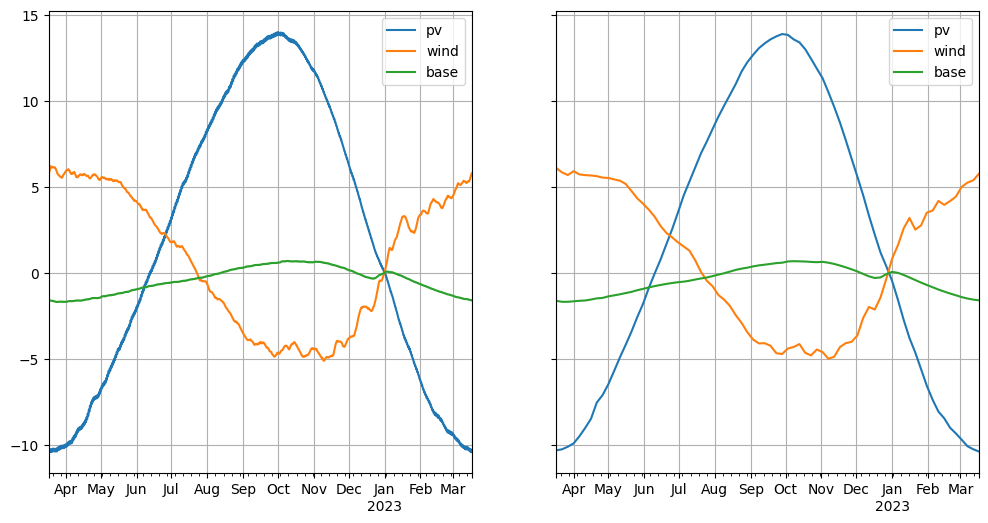

In [41]:
country = "DE"
df_surplus = get_energy_surplus(
    country=country,
    years=years,
    fn_renewable=fn_renewable,
    fn_demand=fn_demand,
    base_demand=100
) 

df_ = df_surplus.cumsum()
# reset such that initial storage is zero for some resources
res = "pv"
df_ = pd.concat([
    df_.loc[df_[res].idxmin():],
    df_.loc[:df_[res].idxmin() - pd.Timedelta(hours=1)],
    ]).set_index(
        pd.date_range(
        start=df_[res].idxmin() - pd.Timedelta(days=365),
        freq="H",
        periods=8760)
        )

fig, axs = plt.subplots(1,2, figsize=(12, 6), sharey=True)
df_.plot(ax=axs[0])
axs[0].grid()
df_.groupby(pd.Grouper(level=0, freq="5D")).mean().plot(ax=axs[1])
axs[1].grid()


(1.0, 52.0)

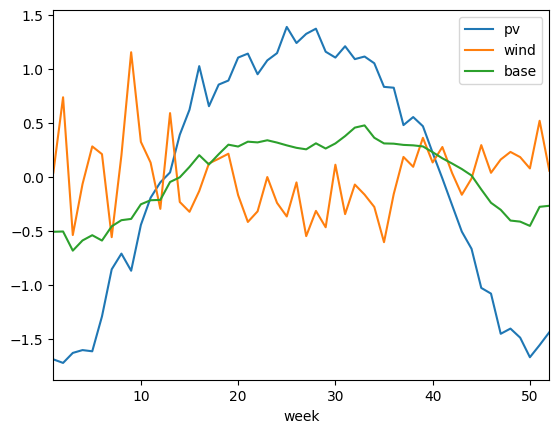

In [10]:
country = "FR"
df_surplus = get_energy_surplus(
    country=country,
    years=years,
    fn_renewable=fn_renewable,
    fn_demand=fn_demand,
    base_demand=100
) 
lst_df = []
for m in range(1,53):
    df_ = df_surplus.loc[df_surplus.index.isocalendar().week == m]
    df_ = df_.cumsum().iloc[-1:,:].assign(week=m)
    lst_df.append(df_)
df_ = pd.concat(lst_df).set_index("week", drop=True)
ax = df_.plot()
ax.set_xlim(1,52) 
#df_

<Axes: xlabel='index'>

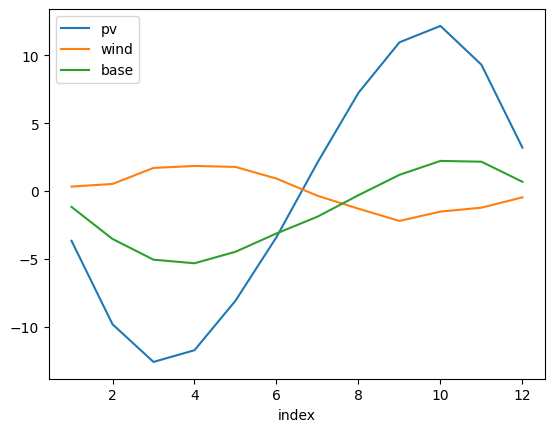

In [11]:
df_surplus.cumsum().groupby(lambda x: x.month).mean().plot()
